# A single model trained on all available data

Data from all clients is pooled to one single dataset and trained in classic fashion. This is only to analyze and compare the trained model with models trained in peer-to-peer environment.

### Using LJ Speech or UserLibri dataset

In [1]:
from environ import set_visible_devices
set_visible_devices('GPU:1')

from models.asr import deep_speech2
import tensorflow as tf
from tensorflow import keras

dataset_choice = 'UserLibri' # or "LJSpeech"

if dataset_choice == 'LJSpeech':
    from data.ljspeech import clients_data
    data = clients_data.load_clients_data(1) # All data will be loaded here and split only to one client
    train_x, train_y = data['train'][0]
    test_x, test_y = data['test'][0]
else:
    from data.userlibri import clients_data
    # Load all 55 clients and combine the data in one dataset
    data = clients_data.load_clients_data(55)
    train_x, train_y = [], []
    test_x, test_y = [], []
    for x, y in data['train']:
        train_x.extend(x)
        train_y.extend(y)
    for x, y in data['test']:
        test_x.extend(x)
        test_y.extend(y)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = clients_data.post_process_dataset(train_dataset, {'batch_size': 8})
validation_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
validation_dataset = clients_data.post_process_dataset(validation_dataset, {'batch_size': 8})

In [2]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        loss, wer_score = deep_speech2.calc_metrics(model, self.dataset)
        logs['wer'] = wer_score
        print(f"Word Error Rate: {wer_score:.4f}")

model = deep_speech2.create_model(rnn_layers=1, rnn_units=512)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[CallbackEval(validation_dataset)]
)

Epoch 1/3
2/2 [==============================] - 7s 2s/step - loss: 1637.2620 - val_loss: 1710.7119
Word Error Rate: 1.1226
Epoch 2/3
2/2 [==============================] - 2s 2s/step - loss: 1531.5535 - val_loss: 1694.2686
Word Error Rate: 1.0000
Epoch 3/3
2/2 [==============================] - 1s 703ms/step - loss: 1460.0056 - val_loss: 1653.7360
Word Error Rate: 1.0000


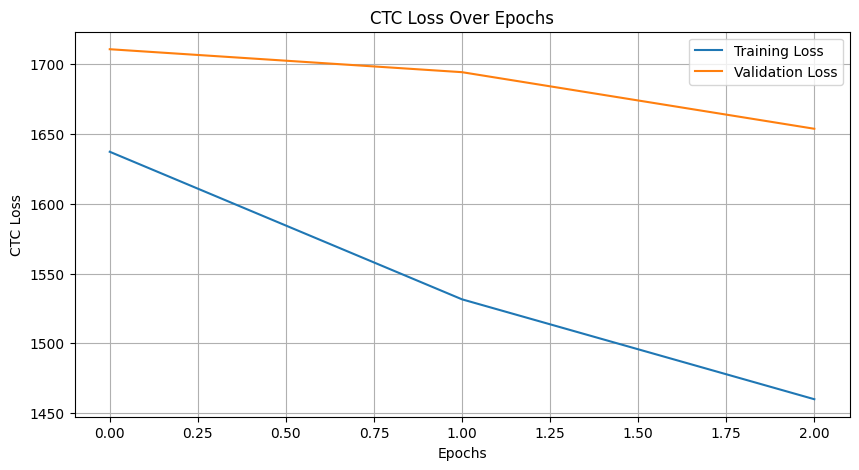

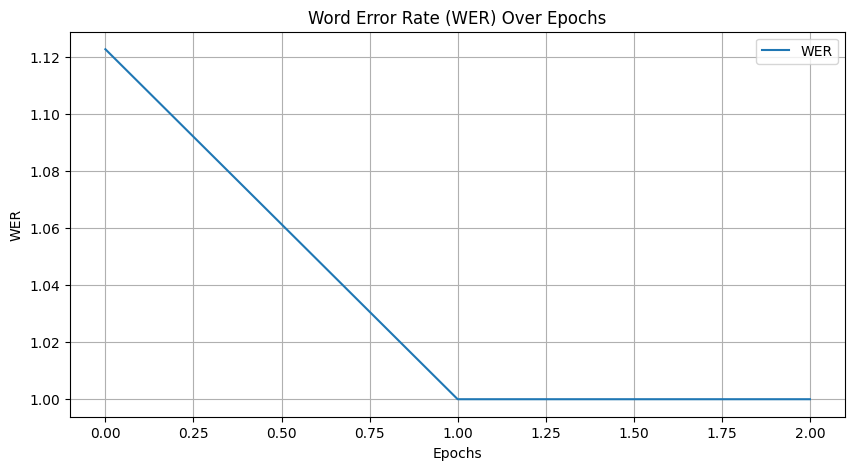

In [3]:
import matplotlib.pyplot as plt

# Plot CTC loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('CTC Loss')
plt.title('CTC Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot WER metric if available
if 'wer' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['wer'], label='WER')
    plt.xlabel('Epochs')
    plt.ylabel('WER')
    plt.title('Word Error Rate (WER) Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()